![Course title](./images/title.png)
<i> Alexey Bochkarev </i> | [🌐 www.bochkarev.io](https://www.bochkarev.io) | [✉ a@bochkarev.io](mailto:a@bochkarev.io)

**Discord:** `co05-как-учить-машины-простые-примеры-про-ml`

# ③ Neural Networks!

Let's make some really hard-to-describe data now.

In [1]:
# data generation
import numpy as np
import pandas as pd

def generate_data():
    X = []; Y = []
    for k in range(1000):
        x1 = np.random.rand()*100.0
        x2 = np.random.rand()*100.0
        if ((x1 > 50) or (x2>50)) and not ((x1>50) and (x2>50)):
            y = 1
        else:
            y =  0
        
        X.append([x1,x2])
        Y.append(y)
    return X, Y
    
X, Y = generate_data()
df = pd.DataFrame({'x1':[x[0] for x in X], 'x2':[x[1] for x in X], 'y':Y})
df.to_csv("./squares.csv")
df.head(10)

,x1,x2,y
0,72.538769,58.155387,0
1,27.942363,26.423649,0
2,74.906589,21.414703,1
3,72.404937,22.539980,1
4,48.679668,38.812417,0
5,70.165887,60.807311,0
6,30.223125,56.253951,1
7,99.147970,96.495794,0
8,69.941868,61.370228,0
9,70.724652,64.401706,0


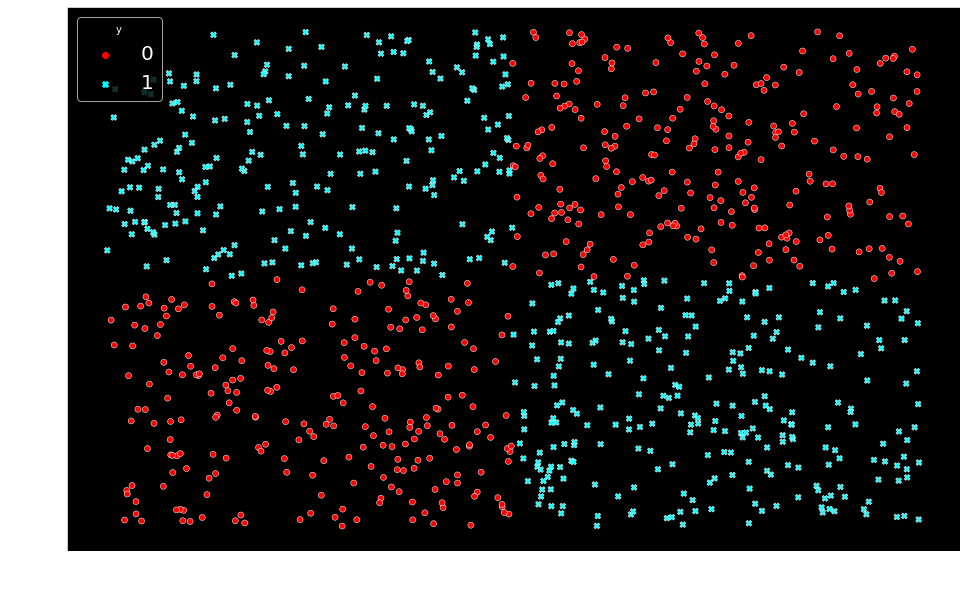

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("dark_background"); plt.rc('legend',fontsize=20)
plt.figure(figsize=(16, 10))

sns.scatterplot(data=df, x="x1", y="x2", hue="y", style="y",
                palette=["red", "cyan"]);
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel("x1", fontsize=22); plt.ylabel("x2", fontsize=22)
plt.show()

## Baseline: quick-and-simple logit

In [3]:
# Okay, baseline
import statsmodels.api as sm

model = sm.Logit(df['y'], sm.add_constant(df[["x1", "x2"]])).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.692152
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      997
Method:                           MLE   Df Model:                            2
Date:                Mon, 11 Jul 2022   Pseudo R-squ.:                0.001364
Time:                        09:33:17   Log-Likelihood:                -692.15
converged:                       True   LL-Null:                       -693.10
Covariance Type:            nonrobust   LLR p-value:                    0.3884
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1026      0.170      0.605      0.545      -0.230       0.435
x1             0.0005      0.

In [4]:
df['baseline_pred_prob'] = model.predict(sm.add_constant(df[["x1", "x2"]]))

threshold = 0.5
df['baseline_pred'] = df['baseline_pred_prob'] >= 0.5

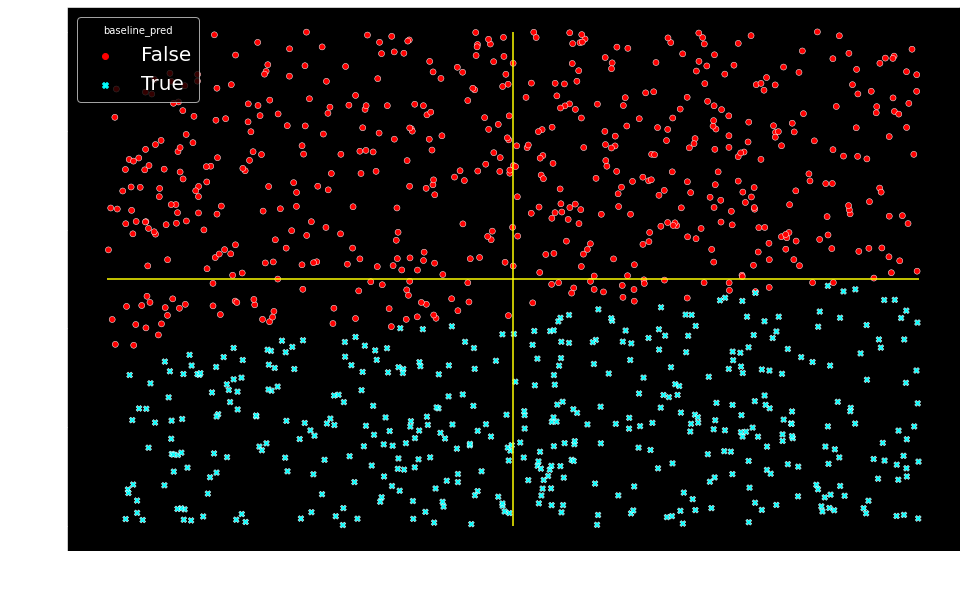

In [5]:
plt.figure(figsize=(16, 10))
sns.scatterplot(data=df, x="x1", y="x2", hue="baseline_pred", style="baseline_pred",
               palette=["red", "cyan"]);
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel("x1", fontsize=22); plt.ylabel("x2", fontsize=22)
plt.hlines(xmin=0, xmax=100, y=[50], color='yellow')
plt.vlines(ymin=0, ymax=100, x=[50], color='yellow')
plt.show()

## We obviously need something better.

Hmmm... What if we stacked a few `logit`s together?..

### A "preceptron"

<div>
<img src="images/neuron.png" width="1000"/>
</div>


### ... aaand we can have a few of those:

<div>
<img src="images/NN.png" width="1000"/>
</div>

## How to use it?

1. How to **predict** is relatively clear, right?
*(Blackboard: forward pass)*

2. But how to **learn**?
*(Blackboard: backward pass)*

In [6]:
from math import exp

def sigmoid(t):
    """Implements the sigmoid function."""
    return 1/(1+exp(-t))


def sprime(t):
    """Calculates the first derivative of the sigmoid."""
    return 1/(exp(-t)+exp(t)+2)

### Ok, let's implement the forward pass:

In [7]:
def forward(W0, W, x1, x2):
    h = [sigmoid(np.dot(W[j], [1, x1, x2]))
                       for j in range(len(W))]
    
    out = sigmoid(np.dot(W0, [1] + h))
    
    return out, h

def forward_batch(W0, W, x_batch):
    """Calculates predicted y-s for a batch of points."""
    return [forward(W0, W, x[0], x[1]) for x in x_batch]

### Then, the loss:

In [8]:
def batch_loss(y_batch, fwd_batch):
    """Calculates loss for a batch of points."""
    return np.sum([(y_batch[i] - fwd_batch[i][0])**2 for i in range(len(y_batch))])

### ... and the *backpropagation* of errors:

In [9]:
def update_weight(W0, W, fwd_pass_batch, y_batch, x_batch, gamma=0.01):
    """Returns a weight increment."""
    # weight increments
    dW = [np.array([0.0, 0.0, 0.0]) for _ in range(len(W))]
    dW0 = np.array([0.0 for _ in range(len(W0))])
    
    for j in range(len(y_batch)):
        x1, x2 = x_batch[j]
        y_pred, h = fwd_pass_batch[j]
        y = y_batch[j]
        
        # update the out-layer weights
        dW0 -= gamma * 2 * (y_pred - y) * sprime(np.dot(W0, [1] + h)) * np.array(
            [1] + h)
        
        # update the hidden layer weights
        for s in range(len(W)):
            dW[s] -=  gamma * 2 * (y_pred - y) * sprime(np.dot(W0, [1] + h)
                                                   ) * sprime(np.dot(W[s], [1, x1, x2])
                                                             ) * np.array([
                        W0[s+1]*1,
                        W0[s+1]*x1,
                        W0[s+1]*x2])
            
    return np.array(dW), dW0

### Now, *train* the whole thing:

In [26]:
from sklearn.utils import shuffle

def train(X, Y, W0_start, W_start, NO_EPOCHS=100, NO_BATCHES=100):
    W = W_start
    W0 = W0_start
    
    losses = []
    NpB = len(Y) // NO_BATCHES
    
    for epoch in range(NO_EPOCHS):
        loss = 0.0
        X, Y = shuffle(X, Y)

        for b in range(NO_BATCHES):
            x_batch = X[b*NpB:(b+1)*NpB]
            y_batch = Y[b*NpB:(b+1)*NpB].values.tolist()
        
            fwd_batch = forward_batch(W0, W, x_batch)
            
            loss += batch_loss(y_batch, fwd_batch)
            
            dW, dW0 = update_weight(W0, W, fwd_batch, y_batch, x_batch, gamma = 0.005)
            W += dW
            W0 += dW0
        
        losses.append(loss)
        if epoch % 1000 == 0:
            print(f"Epoch {epoch} loss: {loss:.1f}")
        
    return W, losses

## Let the magic begin!

In [27]:
from time import time
N_hidden = 2

t0 = time()
W = [[(np.random.rand()-0.5) for _ in range(3)] for _ in range(N_hidden)]
W0 = np.array([np.random.rand() - 0.5 for _ in range(N_hidden+1)])
W, losses = train(df[['x1','x2']].values.tolist(), df['y'], W0, W, 50000)
t1 = time()
print(f"Learning finished in {(t1-t0):.1f} sec.")

Epoch 0 loss: 244.7
Epoch 1000 loss: 177.7
Epoch 2000 loss: 175.4
Epoch 3000 loss: 156.2
Epoch 4000 loss: 156.8
Epoch 5000 loss: 154.9
Epoch 6000 loss: 146.8
Epoch 7000 loss: 147.0
Epoch 8000 loss: 160.3
Epoch 9000 loss: 148.3
Epoch 10000 loss: 150.8
Epoch 11000 loss: 149.8
Epoch 12000 loss: 149.8
Epoch 13000 loss: 146.2
Epoch 14000 loss: 147.6
Epoch 15000 loss: 149.6
Epoch 16000 loss: 151.3
Epoch 17000 loss: 141.1
Epoch 18000 loss: 147.1
Epoch 19000 loss: 145.8
Epoch 20000 loss: 144.7
Epoch 21000 loss: 145.4
Epoch 22000 loss: 147.9
Epoch 23000 loss: 148.1
Epoch 24000 loss: 147.9
Epoch 25000 loss: 146.1
Epoch 26000 loss: 146.2
Epoch 27000 loss: 162.4
Epoch 28000 loss: 143.6
Epoch 29000 loss: 145.9
Epoch 30000 loss: 144.4
Epoch 31000 loss: 150.9
Epoch 32000 loss: 144.1
Epoch 33000 loss: 146.3
Epoch 34000 loss: 149.0
Epoch 35000 loss: 142.3
Epoch 36000 loss: 140.5
Epoch 37000 loss: 146.4
Epoch 38000 loss: 139.6
Epoch 39000 loss: 144.9
Epoch 40000 loss: 143.8
Epoch 41000 loss: 143.1
Epoch

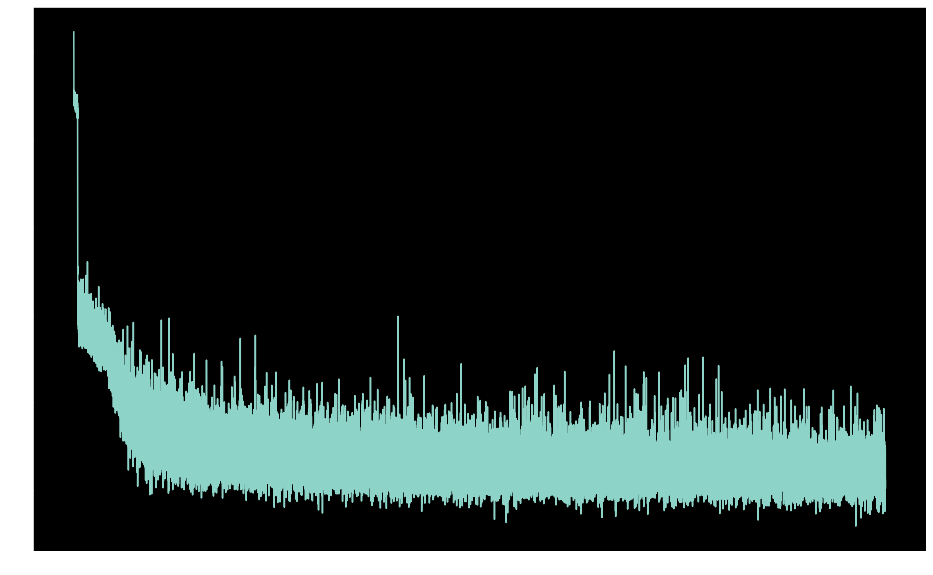

In [28]:
plt.figure(figsize=(16, 10))
plt.plot([j for j in range(len(losses))], losses);plt.show()

In [29]:
df['DN_pred_prob'] = [forward(W0, W, df['x1'][i], df['x2'][i])[0] for i in range(len(df))]
df['DN_pred_prob'].head(10)

0    0.208522
1    0.208522
2    0.881628
3    0.881628
4    0.208522
5    0.208522
6    0.208522
7    0.208522
8    0.208522
9    0.208522
Name: DN_pred_prob, dtype: float64

In [30]:
df['DN_pred'] = df['DN_pred_prob'] >= 0.5
df['DN_pred'].head(10)

0    False
1    False
2     True
3     True
4    False
5    False
6    False
7    False
8    False
9    False
Name: DN_pred, dtype: bool

In [31]:
sum(df['DN_pred'])

375

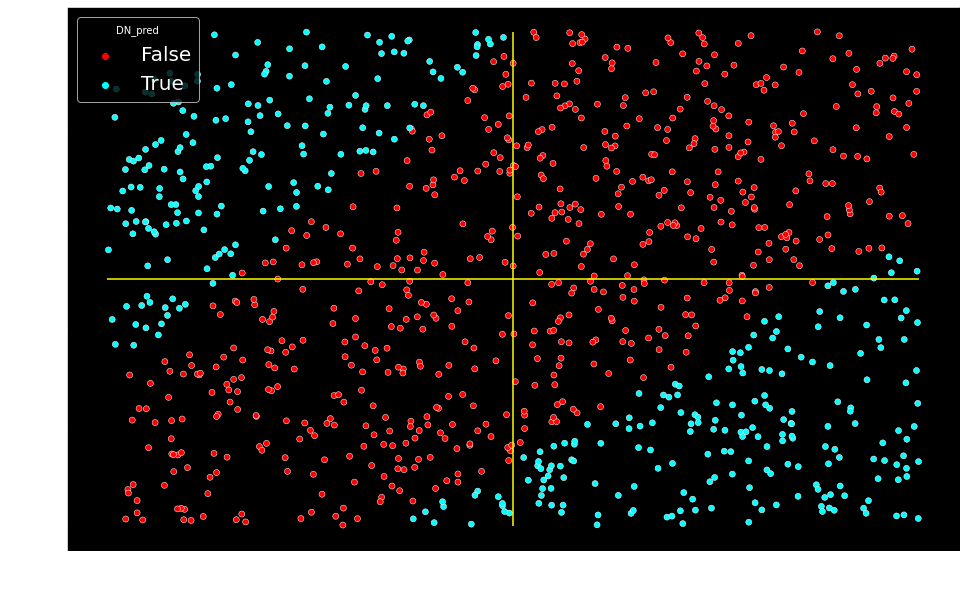

In [32]:
plt.figure(figsize=(16, 10))
sns.scatterplot(data=df, x="x1", y="x2", hue="DN_pred",
               palette=['red', 'cyan']);
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel("x1", fontsize=22); plt.ylabel("x2", fontsize=22)
plt.hlines(xmin=0, xmax=100, y=[50], color='yellow')
plt.vlines(ymin=0, ymax=100, x=[50], color='yellow')
plt.show()

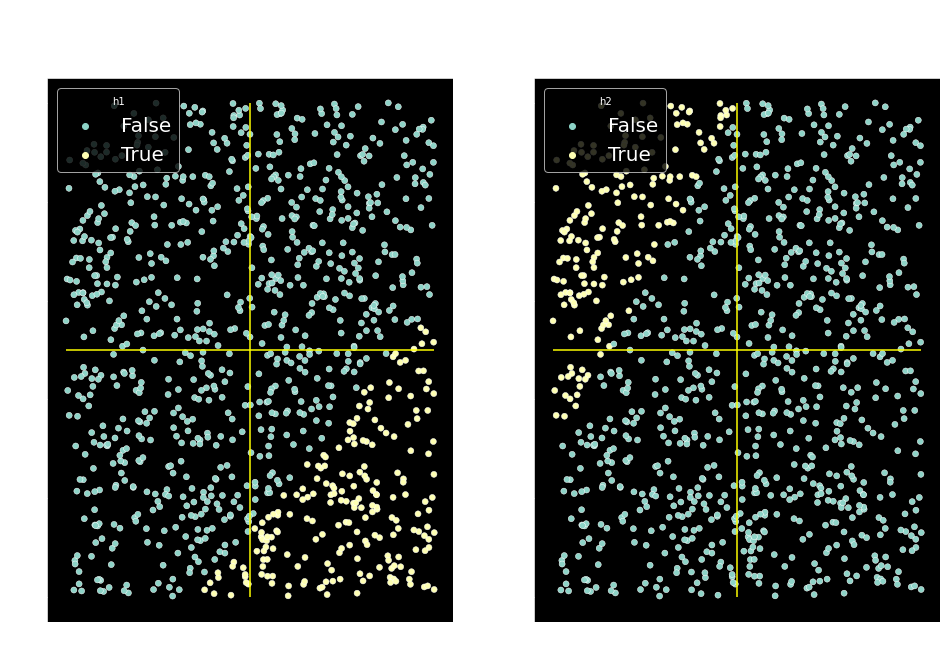

In [33]:
fwd_pass = [forward(W0, W, df['x1'][i], df['x2'][i]) for i in range(len(df))]

for h in range(1, N_hidden + 1):
    df[f"h{h}"] = [fwd_pass[i][1][h-1] >= 0.5 for i in range(len(df))]

fig, ax = plt.subplots(1, N_hidden, figsize=(16,10))
fig.suptitle('Hidden layer activations')

for h in range(1, N_hidden + 1):
    sns.scatterplot(data=df, x="x1", y="x2", hue=f"h{h}",ax=ax[h-1]);
    ax[h-1].hlines(xmin=0, xmax=100, y=[50], color='yellow')
    ax[h-1].vlines(ymin=0, ymax=100, x=[50], color='yellow')
    ax[h-1].set_title(f"Activation of Neuron h{h}", fontsize=22)

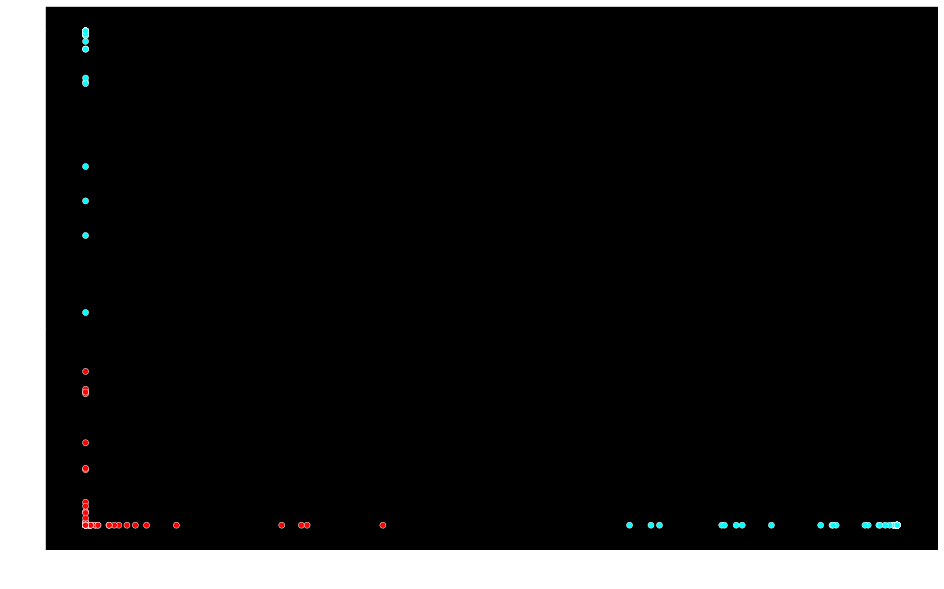

In [34]:
fwd_pass = [forward(W0, W, df['x1'][i], df['x2'][i]) for i in range(len(df))]

df["h1_prob"] = [fwd_pass[i][1][0] for i in range(len(df))]
df["h2_prob"] = [fwd_pass[i][1][1] for i in range(len(df))]

plt.figure(figsize=(16, 10))
sns.scatterplot(data=df, x="h1_prob", y="h2_prob", hue=f"DN_pred",
                palette=['red', 'cyan']);
plt.gca().get_legend().remove()
plt.show()

# Optional topic: Let's make a *DEEP* NN now

In [35]:
def DN_forward(W, V, F, x1, x2):
    h = [sigmoid(np.dot(W[j], [1, x1, x2]))
         for j in range(len(W))]
    d = [sigmoid(np.dot(V[j], [1] + h))
         for j in range(len(V))]
    out = sigmoid(np.dot(F, [1] + d))
    
    return out, h, d

def DN_forward_batch(W, V, F, x_batch):
    """Calculates predicted y-s for a batch of points."""
    return [DN_forward(W, V, F, x[0], x[1]) for x in x_batch]

In [36]:
def DN_update_weight(W, V, F, fwd_pass_batch, y_batch, x_batch, gamma=0.01):
    """Returns a weight increment."""
    # weight increments
    dW = [np.array([0.0, 0.0, 0.0]) for _ in range(2)]
    dV = [np.array([0.0, 0.0, 0.0]) for _ in range(2)]
    dF = np.array([0.0, 0.0, 0.0])
    
    for j in range(len(y_batch)):
        x1, x2 = x_batch[j]
        y_pred, h, d = fwd_pass_batch[j]
        y = y_batch[j]
        
        # update the out-layer weights
        dF -= gamma * 2 * (y_pred - y) * sprime(np.dot(F, [1] + d)) * np.array(
            [1] + d)
        
        # update the second hidden ('deep') layer weights
        for s in range(len(V)):
            dV[s] -=  gamma * 2 * (y_pred - y) * sprime(np.dot(F, [1] + d)
                                            ) * sprime(np.dot(V[s], [1] + h)
                                            ) * F[s+1] * np.array([1] + h)
        
        # update the first hidden layer weights
        for s in range(len(W)):
            dW[s] -= gamma * 2 * (y_pred - y) * sprime(np.dot(F, [1] +d)
                                            ) * (F[1]*sprime(np.dot(V[0], [1]+h)) + (
                                                 F[2]*sprime(np.dot(V[1], [1]+h)))) * sprime(
                                            np.dot(W[s], [1, x1, x2])) * np.array([1, x1, x2])
           
            
    return np.array(dW),np.array(dV), np.array(dF)

In [37]:
def DN_train(X, Y, W_start, V_start, F_start, NO_EPOCHS=100, NO_BATCHES=10):
    W = W_start
    V = V_start
    F = F_start
    
    losses = []
    NpB = len(Y) // NO_BATCHES
    
    for epoch in range(NO_EPOCHS):
        loss = 0.0
        X, Y = shuffle(X, Y)
        
        for b in range(NO_BATCHES):
            x_batch = X[b*NpB:(b+1)*NpB]
            y_batch = Y[b*NpB:(b+1)*NpB].values.tolist()
        
            fwd_batch = DN_forward_batch(W, V, F, x_batch)
            
            loss += batch_loss(y_batch, fwd_batch)
            
            dW, dV, dF = DN_update_weight(W, V, F, fwd_batch, y_batch, x_batch, gamma = 0.01)
            W += dW
            V += dV
            F += dF
        
        losses.append(loss)
        
    return W, V, F, losses

In [38]:
t0 = time()
W = [[(np.random.rand()-0.5) for _ in range(3)] for _ in range(2)]
V = [[(np.random.rand()-0.5) for _ in range(3)] for _ in range(2)]
F = [np.random.rand()-0.5 for _ in range(3)]

W, V, F, losses = DN_train(df[['x1','x2']].values.tolist(), df['y'], W,V,F, 200000)
t1 = time()
print(f"Learning finished in {(t1-t0)/60:.1f} min.")

Learning finished in 232.2 min.


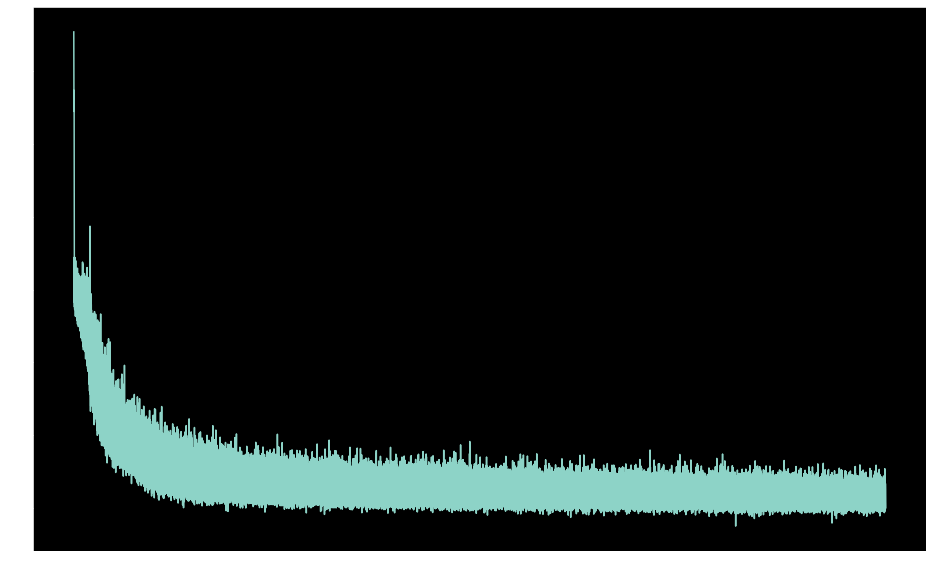

In [39]:
plt.figure(figsize=(16, 10))
plt.plot([j for j in range(len(losses))], losses)

In [40]:
df['DNN_pred_prob'] = [DN_forward(W, V, F, df['x1'][i], df['x2'][i])[0] for i in range(len(df))]
df['DNN_pred_prob'].head(10)

0    0.108120
1    0.095705
2    0.923163
3    0.911209
4    0.099010
5    0.097987
6    0.392096
7    0.095645
8    0.097414
9    0.096373
Name: DNN_pred_prob, dtype: float64

In [41]:
df['DNN_pred'] = df['DNN_pred_prob'] >= 0.5
sum(df['DNN_pred'])

371

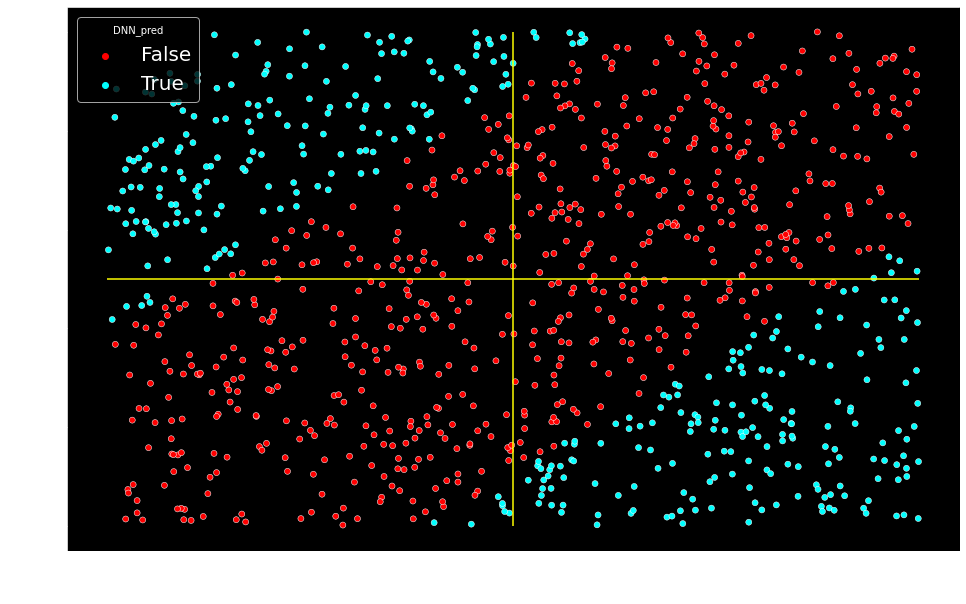

In [43]:
plt.figure(figsize=(16, 10))
sns.scatterplot(data=df, x="x1", y="x2", hue="DNN_pred",
               palette=['red', 'cyan']);
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel("x1", fontsize=22); plt.ylabel("x2", fontsize=22)
plt.hlines(xmin=0, xmax=100, y=[50], color='yellow')
plt.vlines(ymin=0, ymax=100, x=[50], color='yellow')
plt.show()

In [ ]:
fwd_pass2 = [DN_forward(W, V, F, df['x1'][i], df['x2'][i]) for i in range(len(df))]

for h in range(1, N_hidden + 1):
    df[f"h{h}"] = [fwd_pass2[i][1][h-1] >= 0.5 for i in range(len(df))]

fig, ax = plt.subplots(2, 2, figsize=(16,10))
fig.suptitle('Hidden layer activations')

for h in range(1, N_hidden + 1):
    sns.scatterplot(data=df, x="x1", y="x2", hue=f"h{h}",ax=ax[h-1]);
    ax[h-1].hlines(xmin=0, xmax=100, y=[50], color='yellow')
    ax[h-1].vlines(ymin=0, ymax=100, x=[50], color='yellow')
    ax[h-1].set_title(f"Activation of Neuron h{h}", fontsize=22)